In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import cv2
import os

import ipywidgets as iw
from IPython.display import display, clear_output
from skimage.transform import resize as imresize
from keras.preprocessing import image

import keras
from keras import layers, models, optimizers, metrics 
from keras.preprocessing.image import ImageDataGenerator 


# Import various componenets for model building
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.layers import LSTM, Input, TimeDistributed
from keras.models import Model
from keras.optimizers import RMSprop

# Import the backend
from keras import backend as K

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import warnings
# filter warnings
warnings.filterwarnings('ignore')


import os
print(os.listdir("input"))
from subprocess import check_output
print(check_output(["ls", "input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['fruits-360', '.DS_Store']
fruits-360



In [2]:
fruit_names = [k for k in os.listdir('input/fruits-360/Training/')]
print(fruit_names)

['Tomato 4', 'Apple Red Delicious', 'Tomato 3', 'Huckleberry', 'Banana Lady Finger', 'Melon Piel de Sapo', 'Pear', 'Cherry 1', 'Strawberry', 'Avocado', 'Tomato 2', 'Pomegranate', 'Dates', 'Carambula', 'Granadilla', 'Tamarillo', 'Kiwi', 'Cherry Wax Yellow', 'Lemon', 'Guava', 'Apple Golden 2', 'Apple Red 1', 'Mandarine', 'Quince', 'Strawberry Wedge', 'Pear Monster', 'Raspberry', 'Pitahaya Red', 'Apple Golden 3', 'Redcurrant', 'Apple Red Yellow 1', 'Grape Pink', 'Banana Red', 'Physalis', 'Cherry Rainier', 'Maracuja', 'Chestnut', 'Plum', 'Hazelnut', 'Nectarine', 'Cherry Wax Black', 'Cantaloupe 2', 'Lychee', 'Clementine', 'Pear Kaiser', 'Mangostan', 'Cherry 2', 'Pineapple Mini', 'Rambutan', 'Grape White', 'Apple Braeburn', 'Tomato Maroon', 'Mango', 'Cocos', 'Mulberry', 'Avocado ripe', 'Tomato 1', 'Passion Fruit', 'Apple Granny Smith', 'Kumquats', 'Grape White 2', 'Apricot', 'Limes', 'Grape White 4', 'Grape White 3', 'Plum 3', 'Pear Williams', 'Peach 2', 'Pomelo Sweetie', 'Salak', 'Grapefrui

In [3]:
len(fruit_names)

95

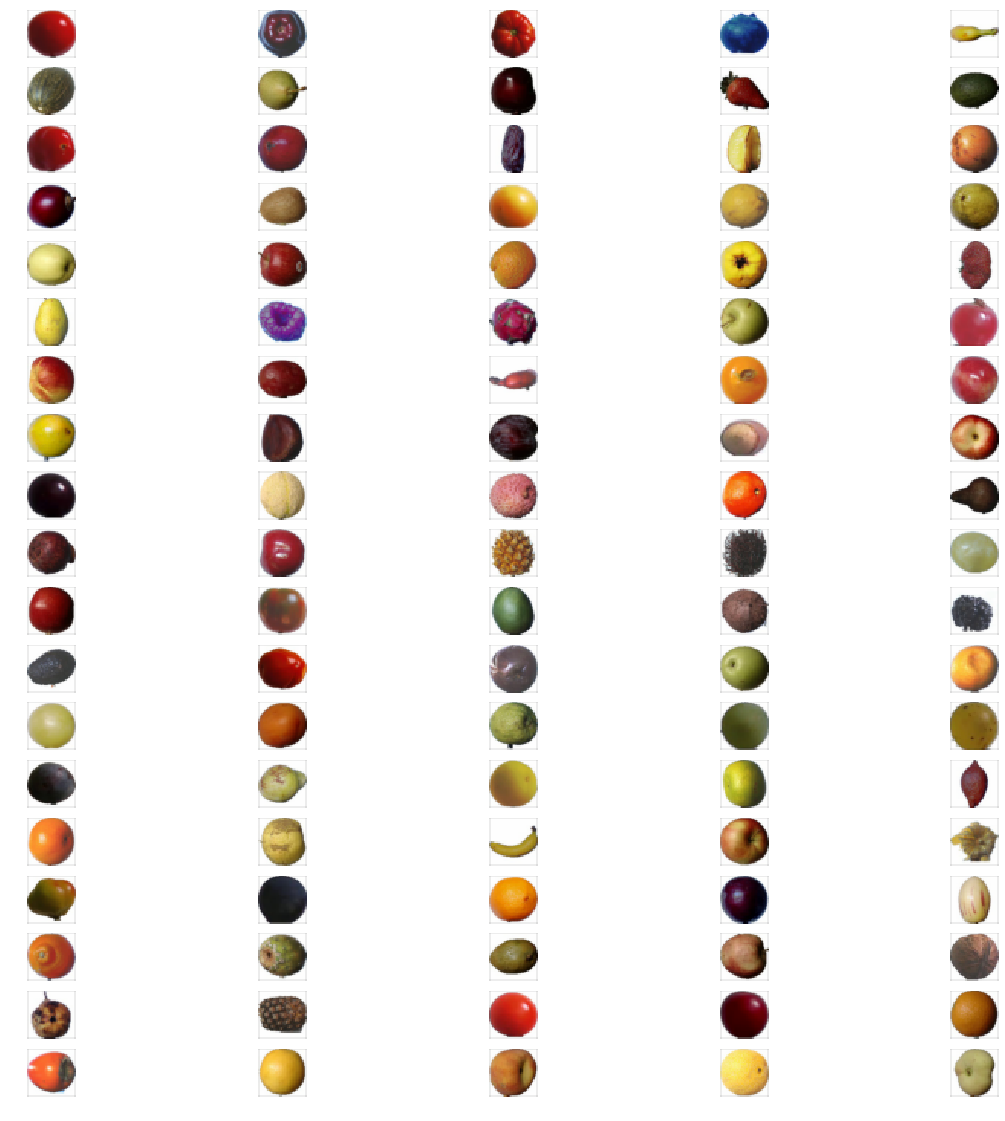

In [4]:
# define the path
path4 = 'input/fruits-360/Training/'

# initializing an array to store resized images
imgs = np.empty([95,32,32,3])

# looping over folders in the training directory
for i, folder in enumerate(os.listdir(path4)):
    
    # selecting first image in the folder
    first_image = (os.listdir(os.path.join(path4,folder)))[0]
    
    # reading the image
    img = plt.imread(os.path.join(path4,folder + '/' + first_image))
    
    # resizing the image
    imgs[i,:,:,:] = imresize(img, (32, 32, 3), mode = 'constant')

# creating 75 subplots with 13 rows and 5 columns
figure, ax = plt.subplots(19,5,figsize = (20, 20))

# initializing count variable i

i = 0

# looping over subplot rows
for k in range(19):
    
    # looping over subplot columns
    for j in range(5):
        # plotting image
        ax[k,j].imshow(imgs[i])
        
        #turning axis off
        ax[k,j].axis('off')
        
        # updating count variable
        i += 1

___

## CNN

In [15]:
CnnP = {'No training images': 37836, 'No validation images': 9554, 'No test images': 3155, 
        'No classes': 95, 'Training batch size': 18, 'Validation batch size': 17, 
        'Training steps/epoch': 2102, 'Validation steps/epoch': 562}

In [16]:
# Initializing a sequential model
model = models.Sequential()

# Adding convolution and maxpooling layers
model.add(layers.Conv2D(32, (3, 3), 
                        activation='relu', 
                        input_shape=(100, 100, 3))) # convolution layer with an output of 32
model.add(layers.MaxPooling2D((2, 2))) # max pooling layer

model.add(layers.Conv2D(64, (3, 3), 
                        activation='relu')) # convolution later
model.add(layers.MaxPooling2D((2, 2))) # maxpooling layer

model.add(layers.Conv2D(128, (3, 3), 
                        activation='relu')) # convolution layer
model.add(layers.MaxPooling2D((2, 2))) # maxpooling layer

model.add(layers.Conv2D(128, (3, 3), 
                        activation='relu')) # convolution layer
model.add(layers.MaxPooling2D((2, 2))) # max pooling layer

# adding a flatten and a dense layer
model.add(layers.Flatten()) # flatten layer and a dropout layer
model.add(layers.Dense(512, 
                       activation='relu')) # dense layer

# output layer with 'softmax' activation as there are multiple classes.
model.add(layers.Dense(CnnP['No classes'], 
                       activation='softmax'))

In [17]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 8, 8, 128)         147584    
__________

In [18]:
model.compile(loss = 'categorical_crossentropy',
              optimizer = optimizers.Adam(lr=1e-4),
              metrics = [metrics.categorical_accuracy])

#### Get Data Ready

In [19]:
# Initializing the ImageDataGenerator object. We set rescale to 1/255 to normalize pixel values to be in range 0,1
datagen = ImageDataGenerator(rescale=1./255)

In [20]:
# Using the generator to get training images ready for the network
train_generator = datagen.flow_from_directory(path4,
                                              target_size = (100,100),
                                              batch_size = CnnP['Training batch size'],
                                              class_mode = 'categorical')

Found 48905 images belonging to 95 classes.


In [21]:
test_path = 'input/fruits-360/Test/'

# Using the generator to get validation images ready for the network
test_generator = datagen.flow_from_directory(test_path,
                                             target_size = (100,100),
                                             batch_size = CnnP['Validation batch size'],
                                             class_mode = 'categorical')

Found 16421 images belonging to 95 classes.


In [23]:
# Fitting the model
history = model.fit_generator(train_generator,
                              steps_per_epoch = CnnP['Training steps/epoch'],
                              epochs = 30,
                              validation_data = test_generator,
                              validation_steps = CnnP['Validation steps/epoch'])

Epoch 1/30
2102/2102 [==============================] - 614s 292ms/step - loss: 0.0396 - categorical_accuracy: 0.9905 - val_loss: 0.1762 - val_categorical_accuracy: 0.9525
Epoch 2/30
2102/2102 [==============================] - 643s 306ms/step - loss: 0.0340 - categorical_accuracy: 0.9918 - val_loss: 0.2199 - val_categorical_accuracy: 0.9560
Epoch 3/30
2102/2102 [==============================] - 620s 295ms/step - loss: 0.0310 - categorical_accuracy: 0.9923 - val_loss: 0.1815 - val_categorical_accuracy: 0.9555
Epoch 4/30
2102/2102 [==============================] - 633s 301ms/step - loss: 0.0118 - categorical_accuracy: 0.9971 - val_loss: 0.0849 - val_categorical_accuracy: 0.9786
Epoch 5/30
2102/2102 [==============================] - 646s 307ms/step - loss: 0.0164 - categorical_accuracy: 0.9962 - val_loss: 0.1013 - val_categorical_accuracy: 0.9800
Epoch 6/30
2102/2102 [==============================] - 652s 310ms/step - loss: 0.0153 - categorical_accuracy: 0.9965 - val_loss: 0.1035 - v

## RNN

In [4]:
np.random.seed(1234)
directory = "input/fruits-360/Training/"
classes= fruit_names

train_arrays=[]
img_size=100
for i in classes:
    path=os.path.join(directory,i)
    class_num=classes.index(i)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        img_array=cv2.resize(img_array,(img_size,img_size))
        train_arrays.append([img_array,class_num])

In [5]:
np.random.seed(1234)
directory="input/fruits-360/Test/"
classes = fruit_names

test_arrays=[]
img_size=100
for i in classes:
    path=os.path.join(directory,i)
    class_num=classes.index(i)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        img_array=cv2.resize(img_array,(img_size,img_size))
        test_arrays.append([img_array,class_num])

In [6]:
import random
random.shuffle(train_arrays)

X_train=[]
Y_train=[]
for features,label in train_arrays:
    X_train.append(features)
    Y_train.append(label)
X_train=np.array(X_train) #arraying

import random
random.shuffle(test_arrays)

X_test=[]
Y_test=[]
for features,label in test_arrays:
    X_test.append(features)
    Y_test.append(label)
X_test=np.array(X_test)

In [ ]:
# Training parameters.
batch_size = 64
num_classes = 95
epochs = 10

# Embedding dimensions.
row_hidden = 32
col_hidden = 32

# Reshapes data to 4D for Hierarchical RNN.
#X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
#X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
print('x_train shape:', X_train.shape)
print(X_train.shape[0], 'train samples')
print(X_test.shape[0], 'test samples')

# Converts class vectors to binary class matrices.
Y_train = keras.utils.to_categorical(Y_train, num_classes)
Y_test = keras.utils.to_categorical(Y_test, num_classes)

row, col, pixel = X_train.shape[1:]

# 4D input.
x = Input(shape=(row, col, pixel))

# Encodes a row of pixels using TimeDistributed Wrapper.
encoded_rows = TimeDistributed(LSTM(row_hidden))(x)

# Encodes columns of encoded rows.
encoded_columns = LSTM(col_hidden)(encoded_rows)

# Final predictions and model.
prediction = Dense(num_classes, activation='softmax')(encoded_columns)
model = Model(x, prediction)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

# Training.
model.fit(X_train, Y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test, Y_test))

# Evaluation.
scores = model.evaluate(X_test, Y_test, verbose=0)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

x_train shape: (48905, 100, 100, 3)
48905 train samples
16421 test samples
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 48905 samples, validate on 16421 samples
Epoch 1/10
48905/48905 [==============================] - 1241s 25ms/step - loss: 4.5431 - acc: 0.0195 - val_loss: 4.5407 - val_acc: 0.0200
Epoch 2/10
32256/48905 [==================>...........] - ETA: 6:09 - loss: 4.3081 - acc: 0.0359

___

___

___

___

___

___

___

## Old / Explorations

In [25]:
np.random.seed(1234)
directory = "input/fruits-360/Training/"
classes= fruit_names

train_arrays=[]
img_size=100
for i in classes:
    path=os.path.join(directory,i)
    class_num=classes.index(i)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        img_array=cv2.resize(img_array,(img_size,img_size))
        train_arrays.append([img_array,class_num])

In [26]:
np.random.seed(1234)
directory="input/fruits-360/Test/"
classes = fruit_names

test_arrays=[]
img_size=100
for i in classes:
    path=os.path.join(directory,i)
    class_num=classes.index(i)
    for img in os.listdir(path):
        img_array=cv2.imread(os.path.join(path,img))
        img_array=cv2.resize(img_array,(img_size,img_size))
        test_arrays.append([img_array,class_num])

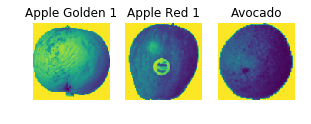

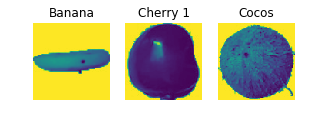

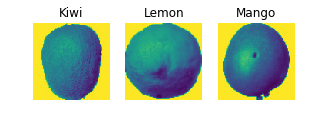

In [14]:
fruits_array_train=[]
for features,label in train_arrays:
    fruits_array_train.append(features)

location=[[1,500,1150],[1500,2000,2500],[3000,3500,4000]]
fruit_names=["Apple Golden 1","Apple Red 1","Avocado","Banana","Cherry 1","Cocos","Kiwi",
             "Lemon","Mango","Orange","Peach","Pomegranate","Raspberry","Strawberry","Tomato 1"]
a=0
b=1
c=2
for i,j,k in location:
    plt.subplots(figsize=(8,8))
    plt.subplot(1,5,1)
    plt.imshow(fruits_array_train[i])
    plt.title(fruit_names[a])
    plt.axis("off")
    plt.subplot(1,5,2)
    plt.imshow(fruits_array_train[j])
    plt.title(fruit_names[b])
    plt.axis("off")
    plt.subplot(1,5,3)
    plt.imshow(fruits_array_train[k])
    plt.title(fruit_names[c])
    plt.axis("off")
    a+=3
    b+=3
    c+=3

In [27]:
fruits = pd.DataFrame(train_arrays)

fruits

,0,1
0,"[[[255, 255, 254], [255, 255, 254], [255, 255,...",0
1,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
2,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
3,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
4,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
5,"[[[255, 255, 249], [255, 255, 251], [255, 255,...",0
6,"[[[255, 255, 248], [255, 255, 249], [255, 255,...",0
7,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
8,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0
9,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",0


In [28]:
import random
random.shuffle(train_arrays)

X_train=[]
Y_train=[]
for features,label in train_arrays:
    X_train.append(features)
    Y_train.append(label)
X_train=np.array(X_train) #arraying

import random
random.shuffle(test_arrays)

X_test=[]
Y_test=[]
for features,label in test_arrays:
    X_test.append(features)
    Y_test.append(label)
X_test=np.array(X_test)

In [30]:
#normalization and reshaping
X_train=X_train.reshape(-1,img_size,img_size,1)
X_train=X_train/255
X_test=X_test.reshape(-1,img_size,img_size,1)
X_test=X_test/255
print("shape of X_train =",X_train.shape)
print("shape of X_test =",X_test.shape)

shape of X_train = (146715, 100, 100, 1)
shape of X_test = (49263, 100, 100, 1)


In [31]:
from keras.utils import to_categorical
Y_train=to_categorical(Y_train,num_classes=len(fruit_names))
Y_test=to_categorical(Y_test,num_classes=len(fruit_names))

Split into test and train set

In [33]:
Y_train.shape

(48905, 95)

In [18]:
from sklearn.model_selection import  train_test_split
x_train, x_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2,random_state=42)

ValueError: Found input variables with inconsistent numbers of samples: [146715, 48905]

In [35]:
from sklearn.metrics import confusion_matrix
import itertools

from keras.utils.np_utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


model=Sequential()
model.add(Conv2D(filters=8,kernel_size=(5,5),padding="Same",activation="relu",input_shape=(100,100,1)))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=16,kernel_size=(4,4),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=32,kernel_size=(4,4),padding="Same",activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(15,activation="softmax"))
#defining optimizer
optimizer=Adam(lr=0.001,beta_1=0.9,beta_2=0.999)
#compile the model
model.compile(optimizer=optimizer,loss="binary_crossentropy",metrics=["accuracy"])

epochs=40
batch_size=45

In [36]:
datagen=ImageDataGenerator(featurewise_center=False, #set input mean to 0
                           samplewise_center=False,  #set each sample mean to 0
                           featurewise_std_normalization=False, #divide input datas to std
                           samplewise_std_normalization=False,  #divide each datas to own std
                           zca_whitening=False,  #dimension reduction
                           rotation_range=0.5,    #rotate 5 degree
                           zoom_range=0.5,        #zoom in-out 5%
                           width_shift_range=0.5, #shift 5%
                           height_shift_range=0.5,
                           horizontal_flip=False,  #randomly flip images
                           vertical_flip=False,
                           )
datagen.fit(x_train)

#model fitting
history=model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),epochs=epochs,
                            validation_data=(x_val,y_val),steps_per_epoch=x_train.shape[0]//batch_size
                           )

Epoch 1/40
133/133 [==============================] - 38s 287ms/step - loss: 0.2446 - acc: 0.9333 - val_loss: 0.2448 - val_acc: 0.9333
Epoch 2/40
133/133 [==============================] - 37s 275ms/step - loss: 0.2445 - acc: 0.9333 - val_loss: 0.2446 - val_acc: 0.9333
Epoch 3/40
133/133 [==============================] - 38s 284ms/step - loss: 0.2445 - acc: 0.9333 - val_loss: 0.2447 - val_acc: 0.9333
Epoch 4/40
133/133 [==============================] - 37s 279ms/step - loss: 0.2445 - acc: 0.9333 - val_loss: 0.2446 - val_acc: 0.9333
Epoch 5/40
133/133 [==============================] - 39s 292ms/step - loss: 0.2444 - acc: 0.9333 - val_loss: 0.2446 - val_acc: 0.9333
Epoch 6/40
133/133 [==============================] - 37s 279ms/step - loss: 0.2444 - acc: 0.9333 - val_loss: 0.2446 - val_acc: 0.9333
Epoch 7/40
133/133 [==============================] - 36s 274ms/step - loss: 0.2443 - acc: 0.9333 - val_loss: 0.2447 - val_acc: 0.9333
Epoch 8/40
133/133 [==============================] - 3

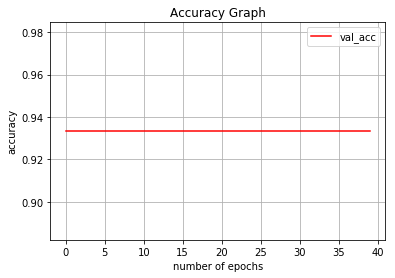

In [37]:
plt.plot(history.history["val_acc"],color="r",label="val_acc")
plt.title("Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

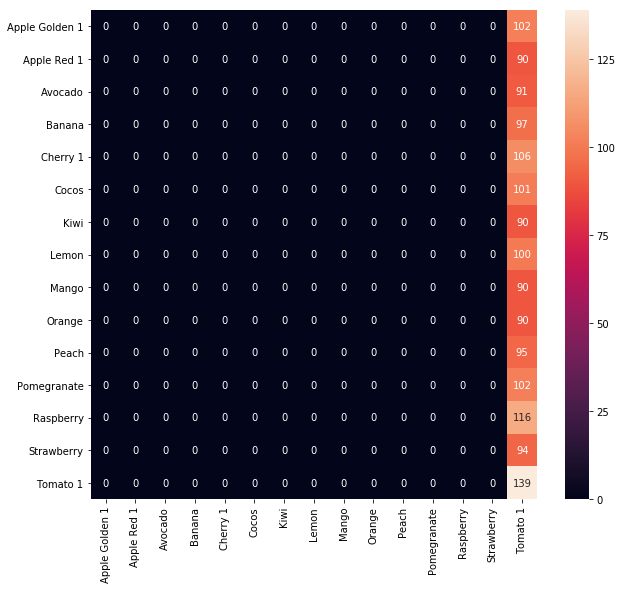

In [42]:
y_pred=model.predict(x_val)
y_pred_classes=np.argmax(y_pred,axis=1)
y_true=np.argmax(y_val,axis=1)
#compute conf mat
conf_mat=confusion_matrix(y_true,y_pred_classes)

fruit_names=["Apple Golden 1","Apple Red 1","Avocado","Banana","Cherry 1","Cocos","Kiwi",
             "Lemon","Mango","Orange","Peach","Pomegranate","Raspberry","Strawberry","Tomato 1"]

#plot the con mat
f,ax=plt.subplots(figsize=(10,9))
sns.heatmap(conf_mat, annot=True, fmt='.0f')
ax.set_xticklabels(fruit_names, rotation='vertical')
ax.set_yticklabels(fruit_names, rotation='horizontal')
plt.show()

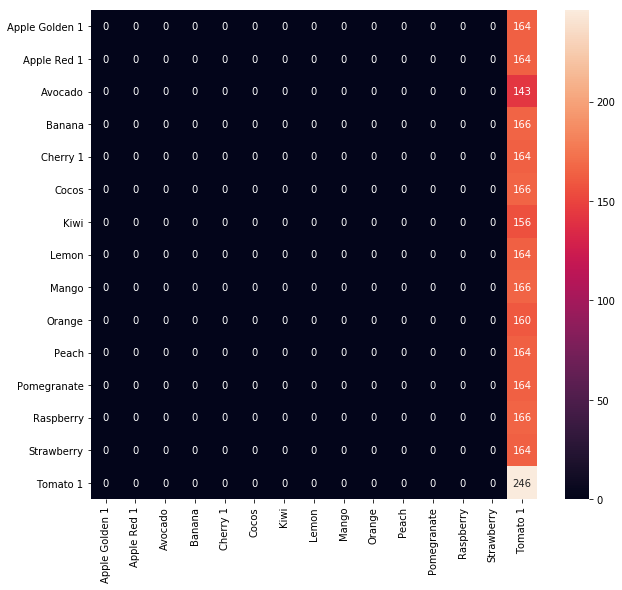

In [43]:
#confusion matrix
y_pred2=model.predict(X_test)
y_pred_classes2=np.argmax(y_pred2,axis=1)
y_true2=np.argmax(Y_test,axis=1)
#compute conf mat
conf_mat2=confusion_matrix(y_true2,y_pred_classes2)
#plot the con mat
f,ax=plt.subplots(figsize=(10,9))
sns.heatmap(conf_mat2,annot=True,fmt=".0f")
ax.set_xticklabels(fruit_names, rotation='vertical')
ax.set_yticklabels(fruit_names, rotation='horizontal')
plt.show()